This is a numerical solution of the evolution of a density matrix

In [1]:
#imorting dependencies
import numpy as np
import sympy as sp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sympy.utilities.lambdify import lambdify #used to make functions out of sympy expressions for
                                              #speeding up the numerical evaluations

In [2]:
#defining symbols
rho_cc = sp.Symbol("rho_cc")
rho_bb = sp.Symbol("rho_bb")
rho_aa = sp.Symbol("rho_aa")
rho_cb = sp.Symbol("rho_cb")
rho_ca = sp.Symbol("rho_ca")
rho_ba = sp.Symbol("rho_ba")
rho_bc = sp.Symbol("rho_bc")
rho_ac = sp.Symbol("rho_ac")
rho_ab = sp.Symbol("rho_ab")

E_c    = sp.Symbol("E_c")
E_b    = sp.Symbol("E_b")
E_a    = sp.Symbol("E_a")

h      = sp.Symbol("h")
Om_cb  = sp.Symbol("\Omega_{cb}")
Om_ba  = sp.Symbol("\Omega_{ba}")
V_cb   = h*Om_cb/2
V_ba   = h*Om_ba/2
om_cb  = sp.Symbol("\omega_{L'}")
om_ba  = sp.Symbol("\omega_{L}")
I      = sp.Symbol("I")
t      = sp.Symbol("t")
e_cb_lower   = sp.exp(I*om_cb*t)
e_cb_upper   = sp.exp(-I*om_cb*t)
e_ba_lower   = sp.exp(I*om_ba*t)
e_ba_upper   = sp.exp(-I*om_ba*t)

values = [(E_c,5),(E_b,4),(E_a,1),(h,1),(Om_cb,1),(Om_ba,1),(om_cb,1.5),(om_ba,2.4),(I,1j)]
rho_sym_l_ex=[sp.re(rho_cc),sp.re(rho_cb),sp.re(rho_ca),
              sp.re(rho_bc),sp.re(rho_bb),sp.re(rho_ba),
              sp.re(rho_ac),sp.re(rho_ab),sp.re(rho_aa),
              sp.im(rho_cc),sp.im(rho_cb),sp.im(rho_ca),
              sp.im(rho_bc),sp.im(rho_bb),sp.im(rho_ba),
              sp.im(rho_ac),sp.im(rho_ab),sp.im(rho_aa)]


In [3]:
#defining matrices
rho = sp.Matrix([
    [rho_cc,rho_cb,rho_ca],
    [rho_bc,rho_bb,rho_ba],
    [rho_ac,rho_ab,rho_aa]
])
RHO =sp.Matrix([
    [sp.re(rho_cc),sp.re(rho_cb)+sp.I*sp.im(rho_cb),sp.re(rho_ca)+sp.I*sp.im(rho_ca)],
    [sp.re(rho_cb)-sp.I*sp.im(rho_cb),sp.re(rho_bb),sp.re(rho_ba)+sp.I*sp.im(rho_ba)],
    [sp.re(rho_ca)-sp.I*sp.im(rho_ca),sp.re(rho_ba)-sp.I*sp.im(rho_ba),sp.re(rho_aa)]
])

H_A =sp.Matrix([
    [E_c,0,0],
    [0,E_b,0],
    [0,0,E_a]
])

V_1 =V_cb*sp.Matrix([
    [0,         e_cb_upper,0],
    [e_cb_lower,0         ,0],
    [0,         0         ,0]
])
V_2 =V_ba*sp.Matrix([
    [0, 0,                 0],
    [0,0         ,e_ba_upper],
    [0,e_ba_lower         ,0]
])

In [4]:
def simplify_matrix(M):
    R = M.copy()
    for i in range(len(M)):
        R[i] = sp.factor(sp.simplify(R[i]))
    return R

In [5]:
first = simplify_matrix((-sp.I/h)*(H_A*rho-rho*H_A))
second= simplify_matrix((-sp.I/h)*(V_1*rho-rho*V_1))
third = simplify_matrix((-sp.I/h)*(V_2*rho-rho*V_2))

FIRST = simplify_matrix((-sp.I/h)*(H_A*RHO-RHO*H_A))
SECOND= simplify_matrix((-sp.I/h)*(V_1*RHO-RHO*V_1))
THIRD = simplify_matrix((-sp.I/h)*(V_2*RHO-RHO*V_2))

full_comm = simplify_matrix(first+second+third)
FULL_COMM = simplify_matrix(FIRST + SECOND + THIRD)

In [6]:

class odeint_complex:
    def __init__(self,rho,rho_expr,values):
        #makes a list of evaluated expressions, except for the variables and time variable
        self.values     =values
        self.rho_l      =self.gen_UpTrn_re(rho)
        self.rho_expr_l =self.gen_UpTrn_re(rho_expr)
        self.rho_expr_l_eval =[]
        for i in range(len(self.rho_expr_l)):
            self.rho_expr_l_eval.append(self.rho_expr_l[i].subs(self.values))
        self.rho_expr_l_eval = np.array(self.rho_expr_l_eval)
        self.define_model_function()
        
    def gen_UpTrn_re(self,M):
        M_=np.array(M)
        M_u=M_[np.triu_indices(M_.shape[0])]
        #M_l=M_[np.tril_indices(M_.shape[0],-1)]
        M_1=np.array([sp.re(M_u[i]) for i in range(len(M_u))])
        M_2=np.array([sp.im(M_u[i]) for i in range(len(M_u))])
        M_ =np.concatenate((M_1,M_2),axis=0)
        return M_

    def define_model_function(self):
        N=len(self.rho_expr_l_eval)
        self.sub_f_re =[lambdify([self.rho_l,t],self.rho_expr_l_eval[i]) for i in range(int(N/2))]
        self.sub_f_im =[lambdify([self.rho_l,t],self.rho_expr_l_eval[i]) for i in range(int(N/2),N)]
        
    def model(self,rho_val_l,t):
        out = []
        for el in self.sub_f_re:
            out.append(el(rho_val_l,t))
        for el in self.sub_f_im:
            out.append(el(rho_val_l,t))
        return out



    def odeint_comp(self,rho_val_l,tspan):
        rho_val_l_out = odeint(self.model,rho_val_l,tspan)[1]  
        return rho_val_l_out
    

In [7]:


rho_val_l = [1,0,0,0,0,0,0,0,0,0,0,0]
def evolve_rho(init_rho_val,values,N,dt):
    #time
    T=N*dt
    t_array=np.linspace(0,T,N)
    print("time")
    print(T)
    ins = odeint_complex(rho,FULL_COMM,values)
    #initial values
    rho_evol =np.empty(N,dtype=list)
    rho_evol[0]=init_rho_val
    for i in range(1,N):
        tspan = [t_array[i-1],t_array[i]]
        rho_evol[i]=ins.odeint_comp(rho_evol[i-1],tspan) 
    return rho_evol
rho_evol = evolve_rho(rho_val_l,values,5000,0.01)
"""
a=np.array([el[1] for el in rho_evol])
b=np.array([el[7] for el in rho_evol])
A=np.array([el[0] for el in rho_evol])
B=np.array([el[3] for el in rho_evol])
C=np.array([el[5] for el in rho_evol])
plt.figure()
plt.plot(t_array,a,'r:',label='real')
plt.plot(t_array,b,'y-',label='imag')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()

plt.figure()

plt.plot(t_array,A,'g:',label='A')
plt.plot(t_array,B,'b-',label='B')
plt.plot(t_array,C,'g-',label='C')
plt.show()"""

time
50.0


"\na=np.array([el[1] for el in rho_evol])\nb=np.array([el[7] for el in rho_evol])\nA=np.array([el[0] for el in rho_evol])\nB=np.array([el[3] for el in rho_evol])\nC=np.array([el[5] for el in rho_evol])\nplt.figure()\nplt.plot(t_array,a,'r:',label='real')\nplt.plot(t_array,b,'y-',label='imag')\nplt.ylabel('values')\nplt.xlabel('time')\nplt.legend(loc='best')\nplt.show()\n\nplt.figure()\n\nplt.plot(t_array,A,'g:',label='A')\nplt.plot(t_array,B,'b-',label='B')\nplt.plot(t_array,C,'g-',label='C')\nplt.show()"

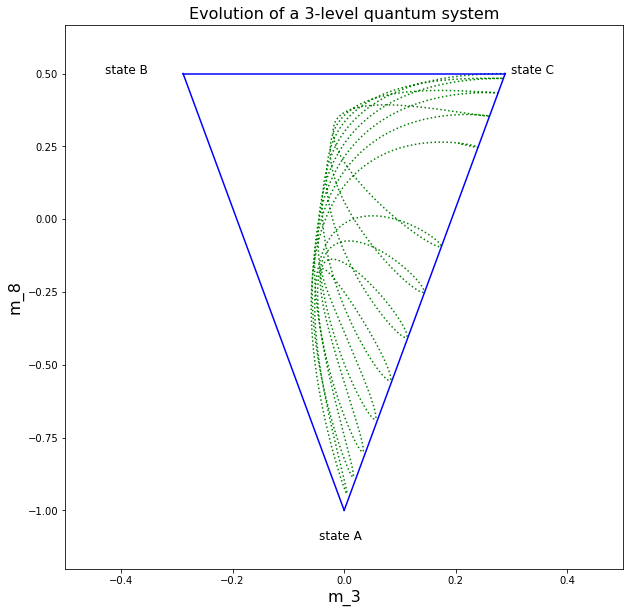

In [8]:
class plotting_m:
    def __init__(self,rho_evol):
        self.rho_evol = rho_evol
        rho_cc_re=np.array([el[0] for el in self.rho_evol])
        rho_cb_re=np.array([el[1] for el in self.rho_evol])
        rho_ca_re=np.array([el[2] for el in self.rho_evol])
        rho_bb_re=np.array([el[3] for el in self.rho_evol])
        rho_ba_re=np.array([el[4] for el in self.rho_evol])
        rho_aa_re=np.array([el[5] for el in self.rho_evol])
        
        rho_cb_im=np.array([el[7] for el in self.rho_evol])
        rho_ca_im=np.array([el[8] for el in self.rho_evol])
        
        rho_ba_im=np.array([el[10] for el in self.rho_evol])
        
        m_8 = (1/2)*(1-3*rho_aa_re)
        m_3 = (1/(2*np.sqrt(3)))*(rho_cc_re-rho_bb_re)
        
        plt.figure(figsize=[10, 10])
        plt.plot(m_3,m_8,'g:')
        
        plt.plot([-1./(2*np.sqrt(3)),1./(2*np.sqrt(3))],[1/2,1/2],'b')
        plt.plot([0,-1/(2*np.sqrt(3))],[-1,1/2],'b')
        plt.plot([0,1/(2*np.sqrt(3))],[-1,1/2],'b')
        plt.text(1./(2*np.sqrt(3))+0.01, 1/2, 'state C', fontsize=12)
        plt.text(-1./(2*np.sqrt(3))-0.14, 1/2, 'state B', fontsize=12)
        plt.text(-0.045, -1-0.1, 'state A', fontsize=12)
        D = 0.0 #the displacement size of the plot
        plt.axis([-1/2-D, 1/2+D, -1.2-D, 2/3+D])
        plt.xlabel("m_3",fontsize=16)
        plt.ylabel("m_8",fontsize=16)
        plt.title("Evolution of a 3-level quantum system",fontsize=16)
        plt.show()
plotting_m(rho_evol)